#Multi-Branch Speech Analysis for Parkinson’s Disease Detection
https://github.com/uanvson/Parkinson_MultiBranch

   ![Multi-Modal](https://raw.githubusercontent.com/uanvson/Parkinson_MultiBranch/refs/heads/main/Muli_modal_parkinson.png)

This study presents a multi-branch framework that integrates a pretrained CNN module with a pretrained Transformer module. By combining the CNN’s ability to extract local time–frequency representations with the Transformer’s capability to model global contextual dependencies, the proposed approach achieves superior performance in Parkinson’s disease detection

In [36]:
# @title Utilities
import torch
import numpy as np
import librosa

def compute_spectrogram(waveform, sample_rate=16000, n_fft=1024, hop_length=512):
    # convert to numpy
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()

    # Compute the STFT
    stft = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)  # Convert to dB scale
    phase = np.angle(stft)  # Get the phase information

    #print(spectrogram.shape)

    return torch.from_numpy(spectrogram).float(), torch.from_numpy(phase).float()

def compute_mel_spectrogram(
    waveform,
    sample_rate=16000,
    n_fft=1024,
    hop_length=512,
    n_mels=128,
    fmin=0,
    fmax=None,
    to_db=True
):
    """
    Compute the Mel-spectrogram from a raw waveform signal.

    Args:
        waveform (torch.Tensor or np.ndarray): 1D input waveform.
        sample_rate (int): Sampling rate of the waveform (Hz).
        n_fft (int): FFT window size for the STFT.
        hop_length (int): Number of samples between successive frames.
        n_mels (int): Number of Mel filter banks.
        fmin (float): Minimum frequency (Hz).
        fmax (float): Maximum frequency (Hz), defaults to Nyquist (sr/2).
        to_db (bool): Whether to convert power values to decibel (dB) scale.

    Returns:
        torch.FloatTensor: Mel-spectrogram with shape [n_mels, time_frames].
    """

    # Convert tensor to numpy array if needed
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.detach().cpu().numpy()

    # Compute Mel-spectrogram (power)
    mel_spec = librosa.feature.melspectrogram(
        y=waveform,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax or sample_rate // 2
    )

    # Optionally convert to dB scale for better dynamic range visualization
    if to_db:
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Convert to PyTorch tensor (float32)
    mel_spec = torch.from_numpy(mel_spec).float()

    return mel_spec


In [39]:
# @title Dateset Class
# ============================================================
# Parkinson Detection - Multi-Branch Fusion (CNN + Transformer)
# ============================================================

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoModel, AutoProcessor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import torchaudio, os
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels =["HC_AH", "PD_AH"] #
class ParkinsonDataset(Dataset):
    def __init__(self, root_dir, processor, img_transform=None):
        self.samples = []
        self.processor = processor
        self.img_transform = img_transform

        for label, cls in enumerate(labels):
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith(".wav"):
                    wav_path = os.path.join(cls_dir, fname)
                    png_path = wav_path.replace("/audio/","/").replace(".wav", ".jpg")
                    #print(fname)
                    #if os.path.exists(png_path):
                    self.samples.append((wav_path, png_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        wav_path, img_path, label = self.samples[idx]

        # Load waveform
        waveform, sr = torchaudio.load(wav_path)
        waveform = torchaudio.functional.resample(waveform, sr, 16000)

        # Whisper processor → Mel log features
        inputs = self.processor(audio=waveform.squeeze().numpy(),
                                sampling_rate=16000, return_tensors="pt")
        wav_input = inputs.input_features.squeeze(0)  # [80, time] ->

        # Load Mel-spectrogram image
        #image,_ = compute_spectrogram(waveform) #Image.open(img_path).convert("RGB")
        spectrogram, _ = compute_spectrogram(waveform)
        if spectrogram.ndim == 3:
          spectrogram = spectrogram.squeeze(0)  # remove extra channel dim

        # Convert to 3-channel NumPy image (for CNN)
        image = np.stack([spectrogram, spectrogram, spectrogram], axis=-1)  # (H, W, 3)
        if self.img_transform:
            image = self.img_transform(image)

        return image, wav_input, label

In [46]:
# @title Define Model
# -------------------------
# Model definition
# -------------------------
class CNNBranch(nn.Module):
    def __init__(self, out_dim=1024):
        super().__init__()
        base = models.inception_v3(models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
        base.fc = nn.Identity()
        for p in base.parameters():
            p.requires_grad = False
        self.base = base
        self.fc = nn.Sequential(
            nn.BatchNorm1d(2048),
            nn.Linear(2048, out_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        # Handle InceptionOutputs object
        outputs = self.base(x)
        if hasattr(outputs, "logits"):  # typical for InceptionV3
            feat = outputs.logits
        elif isinstance(outputs, tuple):  # backward compatibility
            feat = outputs[0]
        else:
            feat = outputs

        return self.fc(feat)


class TransformerBranch(nn.Module):
    def __init__(self, model_name="openai/whisper-tiny", out_dim=512):
        super().__init__()
        from transformers import WhisperModel
        # chỉ load phần encoder (không có decoder)
        whisper = WhisperModel.from_pretrained(model_name)
        self.encoder = whisper.encoder

        for p in self.encoder.parameters():
            p.requires_grad = False  # freeze encoder

        hidden_dim = self.encoder.config.d_model
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        # x shape: [batch, features, time]
        out = self.encoder(x)
        pooled = out.last_hidden_state.mean(dim=1)
        return self.fc(pooled)


class FusionModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = CNNBranch(1024)
        self.trf = TransformerBranch(out_dim=512)

        self.gate = nn.Sequential(nn.Linear(1536, 1536), nn.Sigmoid())
        self.classifier = nn.Sequential(
            nn.Linear(1536, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 2)
        )

    def forward(self, img, wav):
        f1 = self.cnn(img)
        f2 = self.trf(wav)
        fused = torch.cat([f1, f2], dim=1)
        attn = self.gate(fused)
        fused = attn * fused + (1 - attn) * fused.mean(dim=1, keepdim=True)
        return self.classifier(fused)

class FusionModel(nn.Module):
    def __init__(self, use_transformer=True):
        super().__init__()
        self.use_transformer = use_transformer  # <--- new flag

        self.cnn = CNNBranch(1024)
        self.trf = TransformerBranch(out_dim=512)

        # total feature dim changes depending on transformer usage
        fusion_dim = 1024 + (512 if use_transformer else 0)

        self.gate = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 2)
        )

    def forward(self, img, wav=None):
        # CNN branch
        f1 = self.cnn(img)

        # Transformer branch (optional)
        if self.use_transformer and wav is not None:
            f2 = self.trf(wav)
            fused = torch.cat([f1, f2], dim=1)
        else:
            fused = f1  # use only CNN features

        # gating mechanism
        attn = self.gate(fused)
        fused = attn * fused + (1 - attn) * fused.mean(dim=1, keepdim=True)

        # classification head
        return self.classifier(fused)


# -------------------------
# Training & Evaluation
# -------------------------
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    toprint = True

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds, labels = [], []

        for img, wav, y in train_loader:

            # wav = mel (batch,80,3000)  img (4,299,299,3)
            if toprint:
              print(img.shape, wav.shape)
              toprint = False

            img, wav, y = img.to(device), wav.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(img, wav)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds += torch.argmax(logits, dim=1).cpu().tolist()
            labels += y.cpu().tolist()

        acc = accuracy_score(labels, preds)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {total_loss/len(train_loader):.4f} - Acc: {acc:.3f}")

        evaluate(model, val_loader)

def evaluate(model, loader):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for img, wav, y in loader:
            img, wav = img.to(device), wav.to(device)
            logits = model(img, wav)
            pred = torch.argmax(logits, dim=1)
            prob = torch.softmax(logits, dim=1)[:, 1]
            preds += pred.cpu().tolist()
            probs += prob.cpu().tolist()
            labels += y.tolist()

    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    cm = confusion_matrix(labels, preds)
    print(f"Val Accuracy: {acc:.3f} | AUC: {auc:.3f}")
    print("Confusion Matrix:\n", cm)
    print(classification_report(labels, preds, target_names=["HC", "PD"]))
    return acc, auc


# -------------------------
# Run training
# -------------------------
#if __name__ == "__main__":
processor = AutoProcessor.from_pretrained("openai/whisper-tiny")






In [59]:
# @title Train NEW
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def train_modelNEW2(model, train_loader, val_loader, epochs=10, lr=1e-4, patience=3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Danh sách để lưu log
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds, labels = [], []

        # === TRAIN LOOP ===
        for img, wav, y in train_loader:
            img, wav, y = img.to(device), wav.to(device), y.to(device)
            optimizer.zero_grad()

            logits = model(img, wav)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds += torch.argmax(logits, dim=1).cpu().tolist()
            labels += y.cpu().tolist()

        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(labels, preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # === VALIDATION LOOP ===
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad():
            for img, wav, y in val_loader:
                img, wav, y = img.to(device), wav.to(device), y.to(device)
                logits = model(img, wav)
                loss = criterion(logits, y)

                val_loss += loss.item()
                val_preds += torch.argmax(logits, dim=1).cpu().tolist()
                val_labels += y.cpu().tolist()

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}")

        # === EARLY STOPPING ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # === Load best model ===
    model.load_state_dict(torch.load("best_model.pt"))

    # === Vẽ biểu đồ ===
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs_range, val_losses, label="Val Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_accs, label="Train Accuracy", marker='o')
    plt.plot(epochs_range, val_accs, label="Val Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    #return model, train_losses, val_losses, train_accs, val_accs



##Load Dataset:
The Movement Disorders Voice Dataset used in this study
was obtained from the publicly available Kaggle repos-
itory (https://www.kaggle.com/datasets/cycoool29/movement-
disorders-voice).
It consists of a total of 180 voice recordings in .wav format,
each sampled at a frequency of 16 kHz.
Each recording has an average duration of approximately 1
minute and 15 seconds, splitted as:
*  Training set: 100 recordings
*  Test set: 40 recordings

In [41]:
# @title Dataset
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ParkinsonDataset("/content/drive/MyDrive/Colab Notebooks/Parkinson/Augmented/train", processor, img_transform)
test_dataset = ParkinsonDataset("/content/drive/MyDrive/Colab Notebooks/Parkinson/Augmented/test", processor, img_transform)
#dataset = ParkinsonDataset("/content/drive/MyDrive/Colab Notebooks/Parkinson/Dataset/audio", processor, img_transform)

#train_size = int(0.6 * len(dataset))
#val_size = len(dataset) - train_size
#train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_ds = dataset
val_ds = test_dataset

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)



# I. Base Pipeline CNN Only
In this experiment, we evaluate the performance of the baseline pipeline consisting only of the CNN module.

In [52]:
import warnings
warnings.filterwarnings("ignore", message=".*torchcodec.*", module="torchaudio")
warnings.filterwarnings("ignore", message=".*weights.*")

model = FusionModel(use_transformer=False)
train_modelNEW2(model, train_loader, val_loader, epochs=20, lr=1e-4)




/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Image shape: torch.Size([4, 3, 299, 299]), Audio shape: torch.Size([4, 80, 3000])
Epoch 1/20 | Train Loss: 0.7601, Acc: 0.520 | Val Loss: 0.6368, Acc: 0.700
Best model saved at epoch 1 (val_loss=0.6368)
Epoch 2/20 | Train Loss: 0.7044, Acc: 0.585 | Val Loss: 0.5659, Acc: 0.750
Best model saved at epoch 2 (val_loss=0.5659)
Epoch 3/20 | Train Loss: 0.5902, Acc: 0.705 | Val Loss: 0.5347, Acc: 0.800
Best model saved at epoch 3 (val_loss=0.5347)
Epoch 4/20 | Train Loss: 0.5879, Acc: 0.640 | Val Loss: 0.5058, Acc: 0.725
Best model saved at epoch 4 (val_loss=0.5058)
Epoch 5/20 | Train Loss: 0.5930, Acc: 0.670 | Val Loss: 0.5105, Acc: 0.725
No improvement for 1/3 epochs
Epoch 6/20 | Train Loss: 0.5563, Acc: 0.740 | Val Loss: 0.4867, Acc: 0.750
Best model saved at epoch 6 (val_loss=0.4867)
Epoch 7/20 | Train Loss: 0.5267, Acc: 0.740 | Val Loss: 0.4942, Acc: 0.775
No improvement for 1/3 epochs
Epoch 8/20 | Train Loss: 0.5718, Acc: 0.705 | Val Loss: 0.4551, Acc: 0.800
Best model saved at epoch 8 

FusionModel(
  (cnn): CNNBranch(
    (base): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track

In [53]:
evaluate(model, val_loader)

Val Accuracy: 0.850 | AUC: 0.867
Confusion Matrix:
 [[15  5]
 [ 1 19]]
              precision    recall  f1-score   support

          HC       0.94      0.75      0.83        20
          PD       0.79      0.95      0.86        20

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40



(0.85, np.float64(0.8674999999999999))

The base model shows rather good performance with Accuracy: 0.850 | AUC: 0.867

# II. Proposed pipeline: CNN + Tranformer Fusion
In the second experiment, we test the pipeline that combines both the CNN and Transformer modules. The output features from the two branches are concated and fused using a gated self-attention mechanism before being passed to the final classification layer for DP and HC

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Epoch 1/4 | Train Loss: 0.6787, Acc: 0.600 | Val Loss: 0.5456, Acc: 0.875
Epoch 2/4 | Train Loss: 0.5719, Acc: 0.715 | Val Loss: 0.4095, Acc: 0.900
Epoch 3/4 | Train Loss: 0.3958, Acc: 0.840 | Val Loss: 0.2964, Acc: 0.875
Epoch 4/4 | Train Loss: 0.2543, Acc: 0.905 | Val Loss: 0.1810, Acc: 0.975


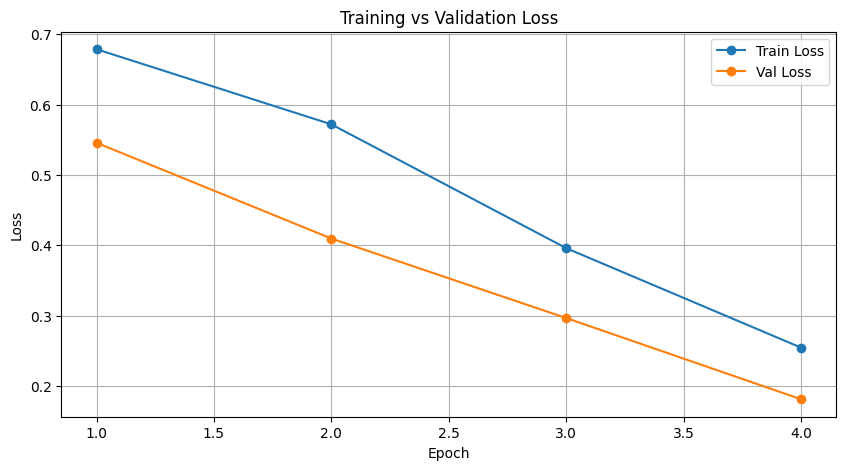

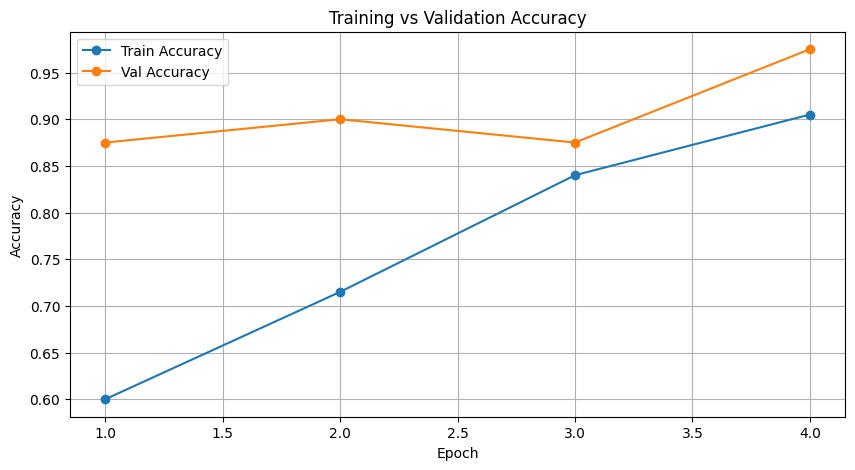

In [60]:
model = FusionModel(use_transformer=True)
train_modelNEW2(model, train_loader, val_loader, epochs=4, lr=1e-4)

In [61]:
evaluate(model, val_loader)

Val Accuracy: 0.975 | AUC: 1.000
Confusion Matrix:
 [[19  1]
 [ 0 20]]
              precision    recall  f1-score   support

          HC       1.00      0.95      0.97        20
          PD       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



(0.975, np.float64(1.0))

## Conclusion:
The fusion model that integrates both CNN and Transformer modules outperforms the CNN-only baseline in terms of accuracy and UAR. This improvement highlights the Transformer’s capability to model global dependencies within the speech features, leading to a more comprehensive representation and improved classification performance.